# Time Series of Atmospheric Pressure


Atmospheric pressure is a key parameter in atmosphere modelling and weather forecasting. In this workshop we analyze atmospheric pressure data. The data is a time series of atmospheric pressure measurements over a period of 2 years, with measurements taken every 4 hours at a certain location on the Earth's surface. The first column is the time in days, starting at zero, the second column is the atmospheric pressure in hPa.

In this workshop we analyze the time series. We first fit a **functional model** to the data in order to stationarize the data. Then we will address the remaining noise and establish a **stochastic model** by fitting an AR(1) model to the residuals.

We begin by loading the data and plotting it.

## Part 0: Load the data and plot it

This week we are using a new library called `statsmodels`. Make sure you use the environment with this library included as done in the PA!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf
import os
from urllib.request import urlretrieve

In [2]:
def findfile(fname):
    if not os.path.isfile(fname):
        print(f"Downloading {fname}...")
        urlretrieve('https://github.com/TUDelft-MUDE/source-files/raw/main/file/WS2.4/'+fname, fname)

findfile('atm_data.txt')

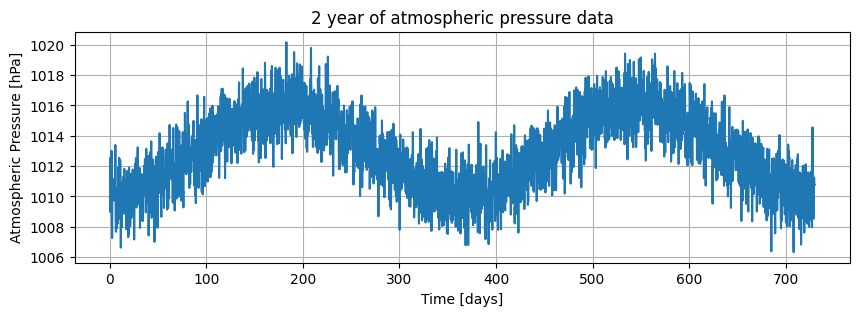

In [3]:
data = np.loadtxt('atm_data.txt', delimiter=',')
time = data[:, 0]
data = data[:, 1]

dt = time[1] - time[0]
fs = 1 / dt

plt.figure(figsize=(10, 3))
plt.plot(time, data)
plt.xlabel('Time [days]')
plt.ylabel('Atmospheric Pressure [hPa]')
plt.title('2 year of atmospheric pressure data')
plt.grid(True)


## Part 1: Finding frequencies of periodic patterns

We clearly see that the data contains a seasonal pattern. We start by fitting a functional model to the data in order to make the data stationary. To find the frequency of the seasonal pattern we will use the power spectrum of the data (periodogram), see [Section 4.3](https://mude.citg.tudelft.nl/book/2025/time_series/modelling.html) 'Time Series modelling and estimation' of the textbook.

The time series may actually be influenced by **multiple** periodic signals at different frequencies; therefore we apply a method to find the dominant frequency, and then 'remove' the corresponding signal from the data (by accounting for it in the functional model, i.e. the A-matrix), and next try again. In this way, multiple periodic signals are handled one-by-one, in an iterative procedure.

Therefore we create a function `find_frequency` that will take the data and an $\mathrm{A}$-matrix as input and return the frequency of the most dominant periodic signal.The A-matrix is built step-wise (each time expanded by adding one or more columns) in order to account eventually for all functional components (including the periodic ones) in the data. Note that we cannot have an empty A-matrix when running the function for the first time. Therefore, we first define an A matrix for a linear model that accounts for an intercept and slope, with which `find_frequency` will then de-trend the time series.

The function will look like this:

1. Using the $\mathrm{A}$-matrix we will fit a model to the data using the least squares method.
2. We will calculate the PSD of the residuals of the model.
3. We will find the frequency of the most dominant periodic signal in the PSD.
4. Optional: we can plot the power spectrum of the data with the highest peak.

### Create the necessary functions

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.1:**
    
Read the code in the next Python cell study the contents until you understand what the functions are doing. Then complete the missing parts of the code.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%"> <p>
<p>

**Tip:**

We will write functions that return multiple parameters, but if we are not interested in defining a particular parameter we can use `_` to ignore it. For example, if we write <code>_, b = function(a)</code>, we only define the second output of the function; the first output is not stored in a variable.

</p></div>

In [4]:
def fit_model(data, time, A, plot=False):
    '''
    Function to find the least squares solution of the data,
    needed in the function 'find_frequency' below
    data: input data
    time: time vector
    A: A-matrix to fit the data
    plot: boolean to plot the results or not
    '''

    x_hat = np.linalg.solve(A.T @ A, A.T @ data)
    y_hat = A @ x_hat
    e_hat = data - y_hat

    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(211)
        plt.plot(time, data, label='Data')
        plt.plot(time, y_hat, label='Estimated data')
        plt.xlabel('Time [days]')
        plt.ylabel('Atmospheric Pressure [hPa]')
        plt.title('Data vs Estimated data')
        plt.grid(True)
        plt.legend()
        plt.subplot(212)
        plt.plot(time, e_hat, label='Residuals')
        plt.xlabel('Time [days]')
        plt.ylabel('Atmospheric Pressure [hPa]')
        plt.title('Residuals')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

    return x_hat, y_hat, e_hat

def find_frequency(data, time, A, fs, plot=True):
    '''
    Function to find the dominant frequency of the signal
    data: input data
    time: time vector
    A: A-matrix to detrend the data (prior to spectral analysis)
    fs: sampling frequency
    plot: boolean to plot the psd or not
    '''
    # Detrending the data
    _, _, e_hat= fit_model(data, time, A)

    N = len(data)

    # Finding the dominant frequency in e_hat
    freqs, pxx = periodogram(e_hat, fs=fs, window='boxcar',
                             nfft=N, return_onesided=False,
                             scaling='density')

    # finding the dominant frequency and amplitude
    # Note: there are many ways to do this
    dominant_frequency, amplitude = freqs[np.argmax(pxx)], np.max(pxx)

    # Plotting the PSD
    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(211)
        plt.plot(time, e_hat)
        plt.title('Residuals')
        plt.ylabel('Atmospheric Pressure [hPa]')
        plt.grid(True)
        plt.subplot(212)
        plt.plot(freqs[freqs>0], pxx[freqs>0], label='PSD of residuals')
        plt.xlabel('Frequency')
        plt.ylabel('PSD')
        plt.title('Power Spectral Density')
        plt.grid(True)
        plt.plot(dominant_frequency, amplitude, 'ro', label='Dominant Frequency')
        plt.yscale('log')
        plt.xscale('log')
        plt.legend()
        plt.tight_layout()

    return dominant_frequency


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.2:**
    
How can we use the <code>find_frequency</code> function to find the frequency of all periodic pattern in the data? In other words, how can we iteratively detect the frequencies in the data? 'Removing' periodic patterns is done by actually accounting for them in the functional model, through the A-matrix.

Write your answer in a bulleted list that describes the procedure in the Markdown cell below.

</p>
</div>


_You may write your answer here if you wish (we will not check this):_
- Step 1: 
- Step 2: 
- Step ...: 
- Step n: 

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

**Solution:**

- Step 1: Run the function
- Step 2: Find dominant frequency
- Step 3: Add the new parameters to the A matrix
- Step 4: Repeat
</p>
</div>

### Find the first dominant frequency

Now we will run `find_frequency` repeatedly to find the frequencies in the data. For the first iteration we will use an $\mathrm{A}$-matrix that will remove a linear trend from the data. When we have found a frequency we will also 'remove' the corresponding signal from the data in the next iteration. 

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.3:**
    
Set up the $\mathrm{A}$-matrix for a linear trend, remove it from the data, then find the most dominant frequency and print the result.

The default units of frequency are cumbersome to interpret, so you should convert the result to a better unit.

</p>
</div>

Dominant Frequency: 0.003 cycle/year
Dominant Frequency: 1.000 cycle/year


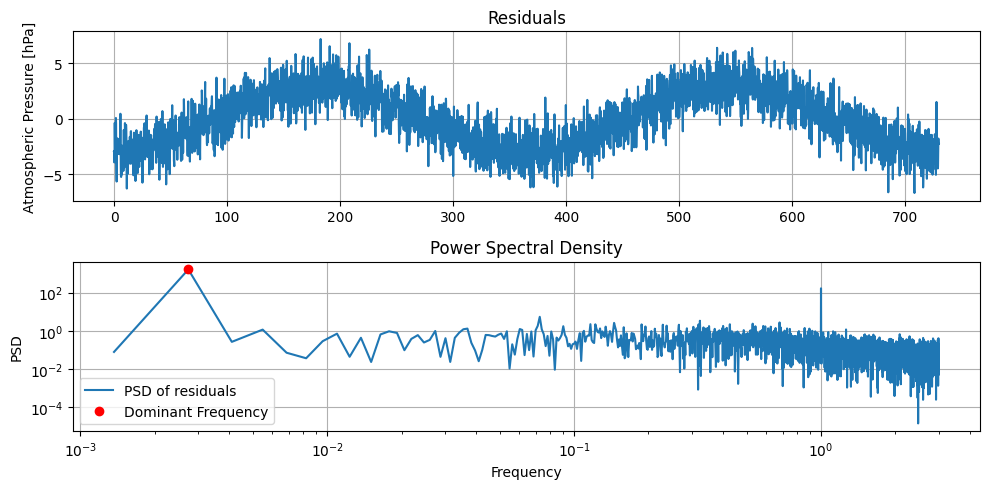

In [5]:
A = np.column_stack((np.ones(len(data)), time))
dom_f = find_frequency(data, time, A, fs)
print(f'Dominant Frequency: {dom_f:.3f} cycle/year')
print(f'Dominant Frequency: {dom_f*365:.3f} cycle/year')

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.4**
    
Look back at the plot of the original time series and confirm whether or not you can see the presence of the signal with the frequency found in the previous task. Write your answer in one sentence in the Markdown cell below.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">

**Solution:**

yes there is a clear yearly pattern in the data 
</p>
</div>

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.5:**
    
Find a second frequency by repeating the process. Before using <code>find_frequency</code> again, the linear trend and first periodic component should be accounted for (through the A-matrix).

Repeat this step until you have removed all dominant signals (you will have to determine when to stop).

Print the frequencies of all periodic signals found in the data.
</p>
</div>

Dominant Frequency: 1.000 cycle/day


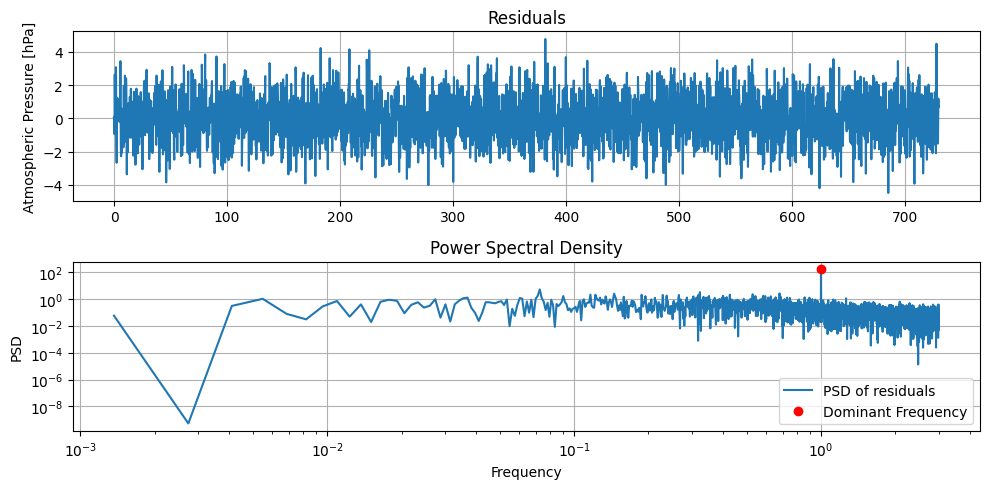

In [6]:
A2 = np.column_stack((A, np.cos(2*np.pi*dom_f*time), np.sin(2*np.pi*dom_f*time)))
dom_f2 = find_frequency(data, time, A2, fs)
print(f'Dominant Frequency: {dom_f2:.3f} cycle/day')

Dominant Frequency: 0.073 cycle/day


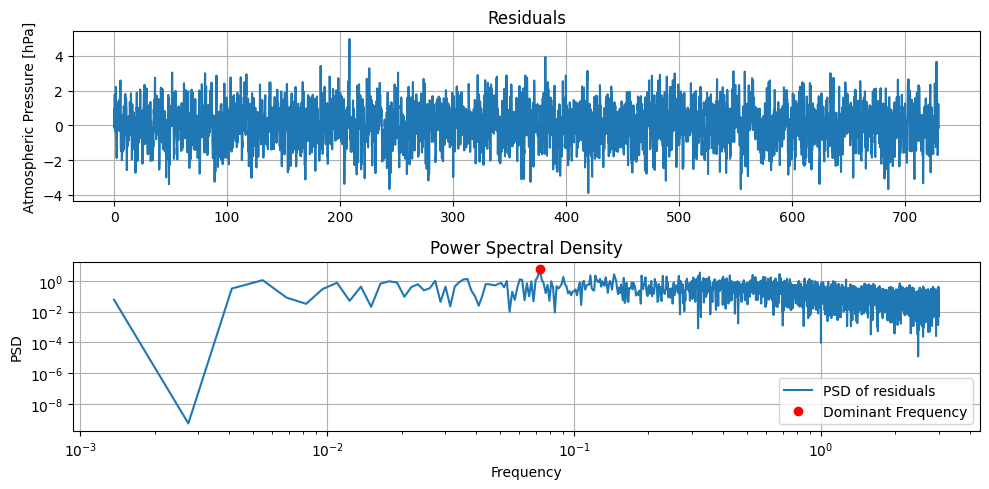

In [7]:
A3 = np.column_stack((A2, np.cos(2*np.pi*dom_f2*time), np.sin(2*np.pi*dom_f2*time)))
dom_f3 = find_frequency(data, time, A3, fs)
print(f'Dominant Frequency: {dom_f3:.3f} cycle/day')

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.6:**
    
Describe the number of steps taken in the previous task and explain in your own words how the dominant frequencies were determined (print them, if you did not already do so).

How did you decide when to stop?

Is the final (detrended) time series (residuals) stationary? Explain.
</p>
</div>

_Your answer here._

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">

**Solution:**

- First run: we fit a linear model to the data and find the dominant frequency of 1 cycle per year. PSD of the residuals is not stationary, so we need to do this again.
- Second run: we fit a model with a linear trend and a yearly cycle. We find a dominant frequency of 1 cycle per day.
- Third run: the highest PSD is a signal with frequency 0.07 cycle/day, which is about 3 orders of magnitude less than the previous run (comparing the order of magnitude on the y-axis between the previous two plots). Therefore, the third frequency is not necessary.
- The previous point illustrates that the detrended series is indeed stationary (there are no significant periodic patterns remaining).

</p>
</div>

## Part 2: Fitting the functional model

In the next cell we will fit the (final) model to generate **stationary residuals**. Above we have used for each dominant frequency $f_i$ ($i=1,2$) the model:

$$
a_i \cos(2\pi f_i t) + b_i \sin(2\pi f_i t)
$$

However, to interpret and report the periodic signals, we would like to have the amplitude, phase shift, and the frequency of those signals, which can be recovered from:

$$
A_i \cos(2\pi f_i t + \theta_i)
$$


Where:
- $A_i=\sqrt{a_i^2+b_i^2}$ 
- $\theta_i=\arctan(-b_i/a_i)$

See section 4.1 in the textbook for more details.


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 2.1:**

Complete the missing parts of the code cell below to create the functional model.

</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%"> <p>
<p>

**text{Tip:**

If you want to compute the $\theta_i$ you can use the <code>np.arctan2</code> function. This function is a version of the arctan function that returns the angle in the correct quadrant $\theta_i \in [-\pi,\pi]$. Using the <code>np.arctan</code> function may not give you the correct angle!
</p>
</div>

In [8]:
def rewrite_seasonal_comp(ak, bk):
    '''
    Function to rewrite the seasonal component in terms of sin and cos
    ak: seasonal component coefficient for cos
    bk: seasonal component coefficient for sin
    '''
    Ak = np.sqrt(ak**2 + bk**2)
    theta_k = np.arctan2(-bk, ak)
    return Ak, theta_k

# creating the A matrix of the functional model
A = np.column_stack((   np.ones(len(data)), time,
                        np.cos(2*np.pi*dom_f*time), np.sin(2*np.pi*dom_f*time),
                        np.cos(2*np.pi*dom_f2*time), np.sin(2*np.pi*dom_f2*time)))

# Finding the Best Linear Unbiased Estimator
x_hat, y_hat, e_hat = fit_model(data, time, A)

# Extracting the seasonal component coefficients from the estimated parameters
a_i = np.array([x_hat[2], x_hat[4]])
b_i = np.array([x_hat[3], x_hat[5]])
freqs = np.array([dom_f, dom_f2])


print(f'Estimated Parameters:')
for i in range(len(x_hat)):
    print(f'x{i} = {x_hat[i]:.2f}')

print('\nThe seasonal component is rewritten as:')
i = 0
for a, b, f in zip(a_i, b_i, freqs):
    A_i, theta_i = rewrite_seasonal_comp(a, b)
    i = i + 1
    print(f'A_{i} = {A_i:.3f}, theta_{i} = {theta_i:.3f}, f_{i} = {f:.3f}')

Estimated Parameters:
x0 = 1012.92
x1 = 0.00
x2 = -2.99
x3 = 0.04
x4 = -0.07
x5 = -0.96

The seasonal component is rewritten as:
A_1 = 2.990, theta_1 = -3.128, f_1 = 0.003
A_2 = 0.959, theta_2 = 1.642, f_2 = 1.000


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 2.2:**
    
- What can you say about the parameters, do the parameters make sense? 

- What time of the day is the pressure highest (on average)?
  
- What has the highest impact on the pressure, the daily or the yearly periodic signal?

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

**Solution:**

Yes, the parameters make sense. The average pressure is about 1013 hPa (the intercept); the slope is 0, so there is no increasing/decreasing trend. Looking at the periodic signals we can see that the daily parameter for theta is 1.6, which is around half of pi, or one-quarter of the daily period. Therefore, the cosine shifts to the left (by a quarter wavelength) and the pressure is lowest around 6 AM and highest around 6 PM (18:00), which would make sense physically for this (simulated) dataset. For the yearly cycles, theta_1 is about - pi, meaning that the cosine shifts to the right (by half a wavelength), meaning the lowest pressure is in Winder (Dec/Jan), and highest pressure in Summer (Jun/Jul). Finally, looking at the amplitude parameters, we can see that the yearly periodic signal has the highest impact on the pressure.
</p>
</div>

## Part 3: Analyzing the residuals - developing the stochastic model

Now that we have our (stationary) residuals, we can fit an AR model to these residuals. We start by plotting the ACF of the residuals. We then fit an AR model to the residuals and report the parameter(s) of the AR model.

### Part 3.1: Plot the ACF of the residuals

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 3.1:**
    
Use the <code>plot_acf</code> function (from statsmodels) to plot the ACF (normalized autocovariance function) $\hat{\rho}_{\tau}$ of the residuals from the least-squares model fit of Part 2. The Autocovariance function (ACF) is covered in Section 4.5 of the textbook.

</p>
</div>

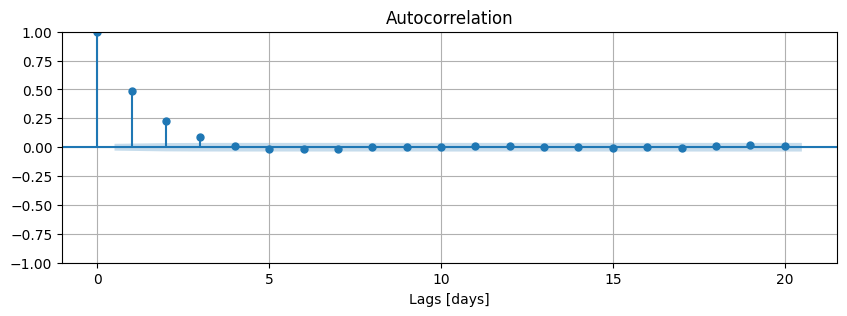

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_acf(e_hat, ax=ax, lags=20);
ax.set_xlabel('Lags [days]')
ax.grid()

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 3.2:**
    
What can you conclude from this ACF? Do the residuals originate from a white noise process?
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">

**Solution:**

The data is autocorrelated (colored noise) since lags are significantly correlated (up to lag 3).

The residuals do not originate from a white noise process; they show some kind of 'memory'.
</p>
</div>

### Part 3.2: Fit an AR(1) model to the residuals

First we write a function `AR1` that will take the stationary residuals as input and return the parameters of the AR1 model. Then we will fit this model to the residuals and report the parameters.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 3.3:**
    
Complete the missing parts of the code cell below.
</p>
</div>

In [10]:
def AR1(s, time, plot=True):
    '''
    Function to find the AR(1) model of the given data
    s: input data
    return: x_hat, e_hat
    '''
    y = s[1:]
    y_lag_1 = s[:-1]
    # np.atleast_2d is used to convert the 1D array to 2D array,
    # as the fit_model function requires 2D array
    A = np.atleast_2d(y_lag_1).T 

    x_hat, y_hat, e_hat = fit_model(y, time, A)
    if plot:
        plt.figure(figsize=(10, 3))
        plt.plot(time, y, label='Original Residuals')
        plt.plot(time, y_hat, label='Estimated Residuals')
        plt.xlabel('Time [days]')
        plt.ylabel('Atmospheric Pressure [hPa]')
        plt.title('Original Data vs Estimated Data')
        # plt.xlim([0, 100]) # uncomment this line to zoom in, for better visualization
        plt.grid(True)
        plt.legend()

    print(f'Estimated Parameters:')
    print(f'phi = {x_hat[0]:.4f}')

    return x_hat, e_hat


### Part 3.3: Perform the fit of an AR1 model to the residuals

Using the AR1-function created above, fit an AR(1) model to the residuals of the functional model (found in Part 2), then report the parameters. We need to check if the AR(1) model is a good fit to the residuals. There are several ways to check whether this is the case.

Today is your lucky day: we use a simple method. If the AR(1) model is a good fit to the residuals, the residuals remaining AFTER applying the AR(1) model (residuals output by the `AR1` function) should be white noise. We will plot the ACF of the residuals of the AR(1) model to check if this is the case.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 3.4:**
    
Complete the missing parts of the code cell below.
</p>
</div>

Estimated Parameters:
phi = 0.4908


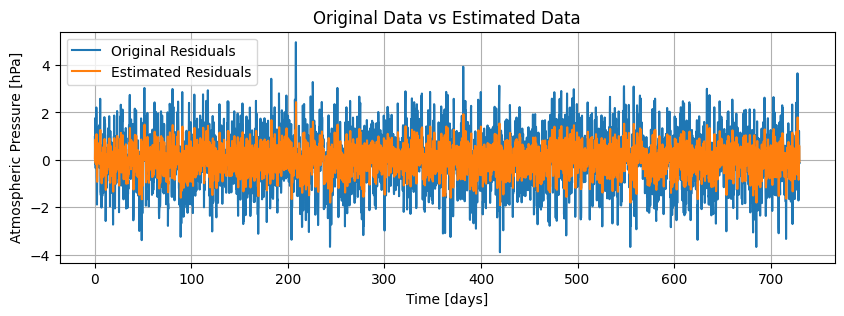

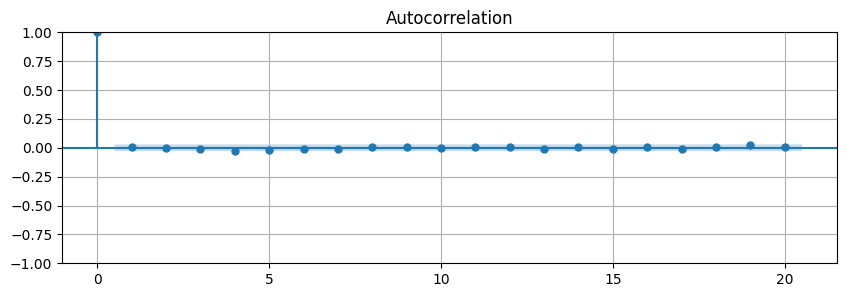

In [11]:
_, e_hat2 = AR1(e_hat, time[1:])

# Lets start with the ACF plot
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_acf(e_hat2, ax=ax, lags=20);
ax.grid()

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 3.5:**
    
- What can you conclude from this ACF?
  
- Is the AR(1) model a good fit to the residuals?
  
- What would you do if the AR(1) model is not a good fit to the residuals?
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

**Solution:**

No autocorrelation in the residuals of the AR(1) model (remaining residuals seem to result from a white noise process), so the AR(1) model is a good fit to the residuals. If the AR(1) model is not a good fit to the residuals we could try a higher order AR model (beyond the scope of the MUDE).
</p>
</div>

## Conclusion

We have formed both the functional and stochastic model for the atmospheric pressure time series. The functional model consists of a linear trend (intercept and slope), and two periodic patterns ('frequencies'). The stochastic model is formed by an AR(1) process and we determined the $\varphi_1$ parameter.

Now all is in place for forecasting, see Section 4.8 'Time Series forecasting' in the textbook, and we will do so with the GA.


> By Christiaan Tiberius Delft University of Technology. CC BY 4.0, more info [on the Credits page of Workbook](https://mude.citg.tudelft.nl/workbook-2025/credits.html).